# Training M5 CNN for Raspberry Pi
**Tomas Perez-Rodriguez**  
for **EEP590 Spring 2022**, *Prof. Shi*

Project and supporting files available at https://github.com/tper0700/SpeechCommandsCNN

## Introduction

This project presents a command recognition model to run on the Raspberry Pi platform. This report includes the background for how this solution came about, the analysis of the model, and a discussion of the lessons learned along the way.

The initial design for the project was to build a portable speech recognition device that could recognize sentences spoken in another language. The driving intuition was to train an RNN on a labeled set of sentences spoken in the given language. The RNN approach was chosen because it seemed reasonable to adopt the ImprovedRNN model developed in assignment 3 as a C++ model using Halide or other math libraries. Given the goal of this project to train a model, compress/quantize it, and finally implement the inference in C++ for embedded applications, this seemed like a reasonable approach. What follows is a brief discussion of initial model training and the lessons and experiences that led to looking for a different, proof of concept project. Next up is a detailed explanation of a smaller project undertaken that shows the feasibility of speech recognition in the embedded device. Finally, the conclusions will review how the project could be taken further, and how it built the enabling technologies to build the language recognition device.


## Exploring data modeling


After a survey of Kaggle data sets available for speech recognition, the following recognition project stood out as an interesting modeling problem to solve.

* [Spanish Automatic Speech Recognition pytorch](https://www.kaggle.com/code/shwetanani/spanish-automatic-speech-recognition-pytorch/notebook#Test-the-Conv-GRU-Model)
* Based on the [120h Spanish Speech](https://www.kaggle.com/datasets/carlfm01/120h-spanish-speech) dataset.

This project, and the related [Japanese Single Speaker Speech Dataset](https://www.kaggle.com/datasets/bryanpark/japanese-single-speaker-speech-dataset) were the inspiration for the project. While the original project uses stacked RNNs to train on the dataset, the goal of this project was to explore if a single RNN could possibly learn similar results. Unfortunately the answer was no.

The first step was to build a dataset loader for this data (results in the [Loading_Data_Sets notebook](Loading_Data_Sets.ipynb). Upon loading the data and reviewing materials studied in this course, it became evident that training this set would require a significant amount of computing resources to predict a sequence of words, and that a straightforward RNN would not be able to make a reasonable prediction by itself.

In order to experiment with label management and the inference process, the language inference was put on hold, and the experiment focused on the SpeechCommands data set.


## Exploring Speech Commands inference with RNN

The first approach was to attempt to replicate the results from [Speech Command Classification with torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html) provided by pyTorch, but using the ImprovedRNN from the course [Training_Yes_No_Batches](Training_Yes_No_Batches.ipynb). It was quickly found that performing the operations in python (even with CUDA) was significantly slower than using the built in RNN, so a training attempt was made with the built in RNN [Training_Yes_No_Torch](Training_Yes_No_Torch.ipynb).

The pytorch RNN test showed that while a model could be built, training would be difficult or almost impossible based on early results (very low accuracy in results). So even if an RNN could be implemented in C++, a simple straightforward RNN could not be trained without building a more complex model.

This led to stepping back again to focus on the goal of implementing an effective inference in C++.

## Speech Commands CNN

Again based on [Speech Command Classification with torchaudio](https://pytorch.org/tutorials/intermediate/speech_command_recognition_with_torchaudio.html). The project shifted to leveraging the CNN model demonstrated in the Pytorch documentation, itself based on the M5 deep CNN described by Dai et al. in their paper [VERY DEEP CONVOLUTIONAL NEURAL NETWORKS FOR RAW WAVEFORMS](https://arxiv.org/pdf/1610.00087.pdf). The implementation sections below detail the implementation of this model.


## OpenCV for Audio and ONNX

After implementing the full solution, and before coding the entire model in C++, a search of libraries that could convert the pytorch model to C++ led to the ONNX format, and to the opencv compatibility with this format. In essence, the pytorch model can be exported to an ONNX file, and then imported by opencv to generate an inference model.

This left open two questions: can OpenCV operate on audio, and can OpenCV operate on Rasbperry Pi. Fortunately, the answer to these questions is yes, with some caveats.

* OpenCV operates on images. It cannot open wav files. Another library, [Dr Wav](https://mackron.github.io/dr_wav) was used to quickly and efficiently load the wav files into memory. Once in memory, they were loaded into an OpenCV Mat object and converted to the right shape desired. The application loads the wav file at 16000 KHz and downsamples to 4000 KHz for inference (more on this decision below).
* Raspberry Pi OS suppors OpenCV 4 and [libopencv-dnn4.5](https://packages.debian.org/bullseye/libopencv-dnn4.5) as of **Debian bullseye**. This dependency can be easily satisfied via package installation.

These two design choices allowed for quick prototyping of a solution to demonstrate the feasibility of inference in C++ on the device.

The inference implemented is a simple C++ file in [src/processor/main.cpp](src/processor/main.cpp).

## Hardware issues

Armed with an inference for Raspberry Pi, the project then continued to try to make an inference using a microphone. Since the Raspberry Pi does not have a microphone embedded, two microphone boards were acquired and tested. However, it is unclear why neither board is functional. Both boards load into the alsa sound system in the PI device:

```
pi@pidca632cd00ce:~ $ aplay -l
**** List of PLAYBACK Hardware Devices ****
card 0: sndrpigooglevoi [snd_rpi_googlevoicehat_soundcar], device 0: Google voiceHAT SoundCard HiFi voicehat-codec-0 [Google voiceHAT SoundCard HiFi voicehat-codec-0]
  Subdevices: 1/1
  Subdevice #0: subdevice #0
card 1: vc4hdmi0 [vc4-hdmi-0], device 0: MAI PCM i2s-hifi-0 [MAI PCM i2s-hifi-0]
  Subdevices: 1/1
  Subdevice #0: subdevice #0
card 2: vc4hdmi1 [vc4-hdmi-1], device 0: MAI PCM i2s-hifi-0 [MAI PCM i2s-hifi-0]
  Subdevices: 1/1
  Subdevice #0: subdevice #0
```

However no audio plays, and no sounds are recorded via alsa. This means the ability of the project to record and infer on realtime audio is blocked until a hardware device with recording capability is identified.

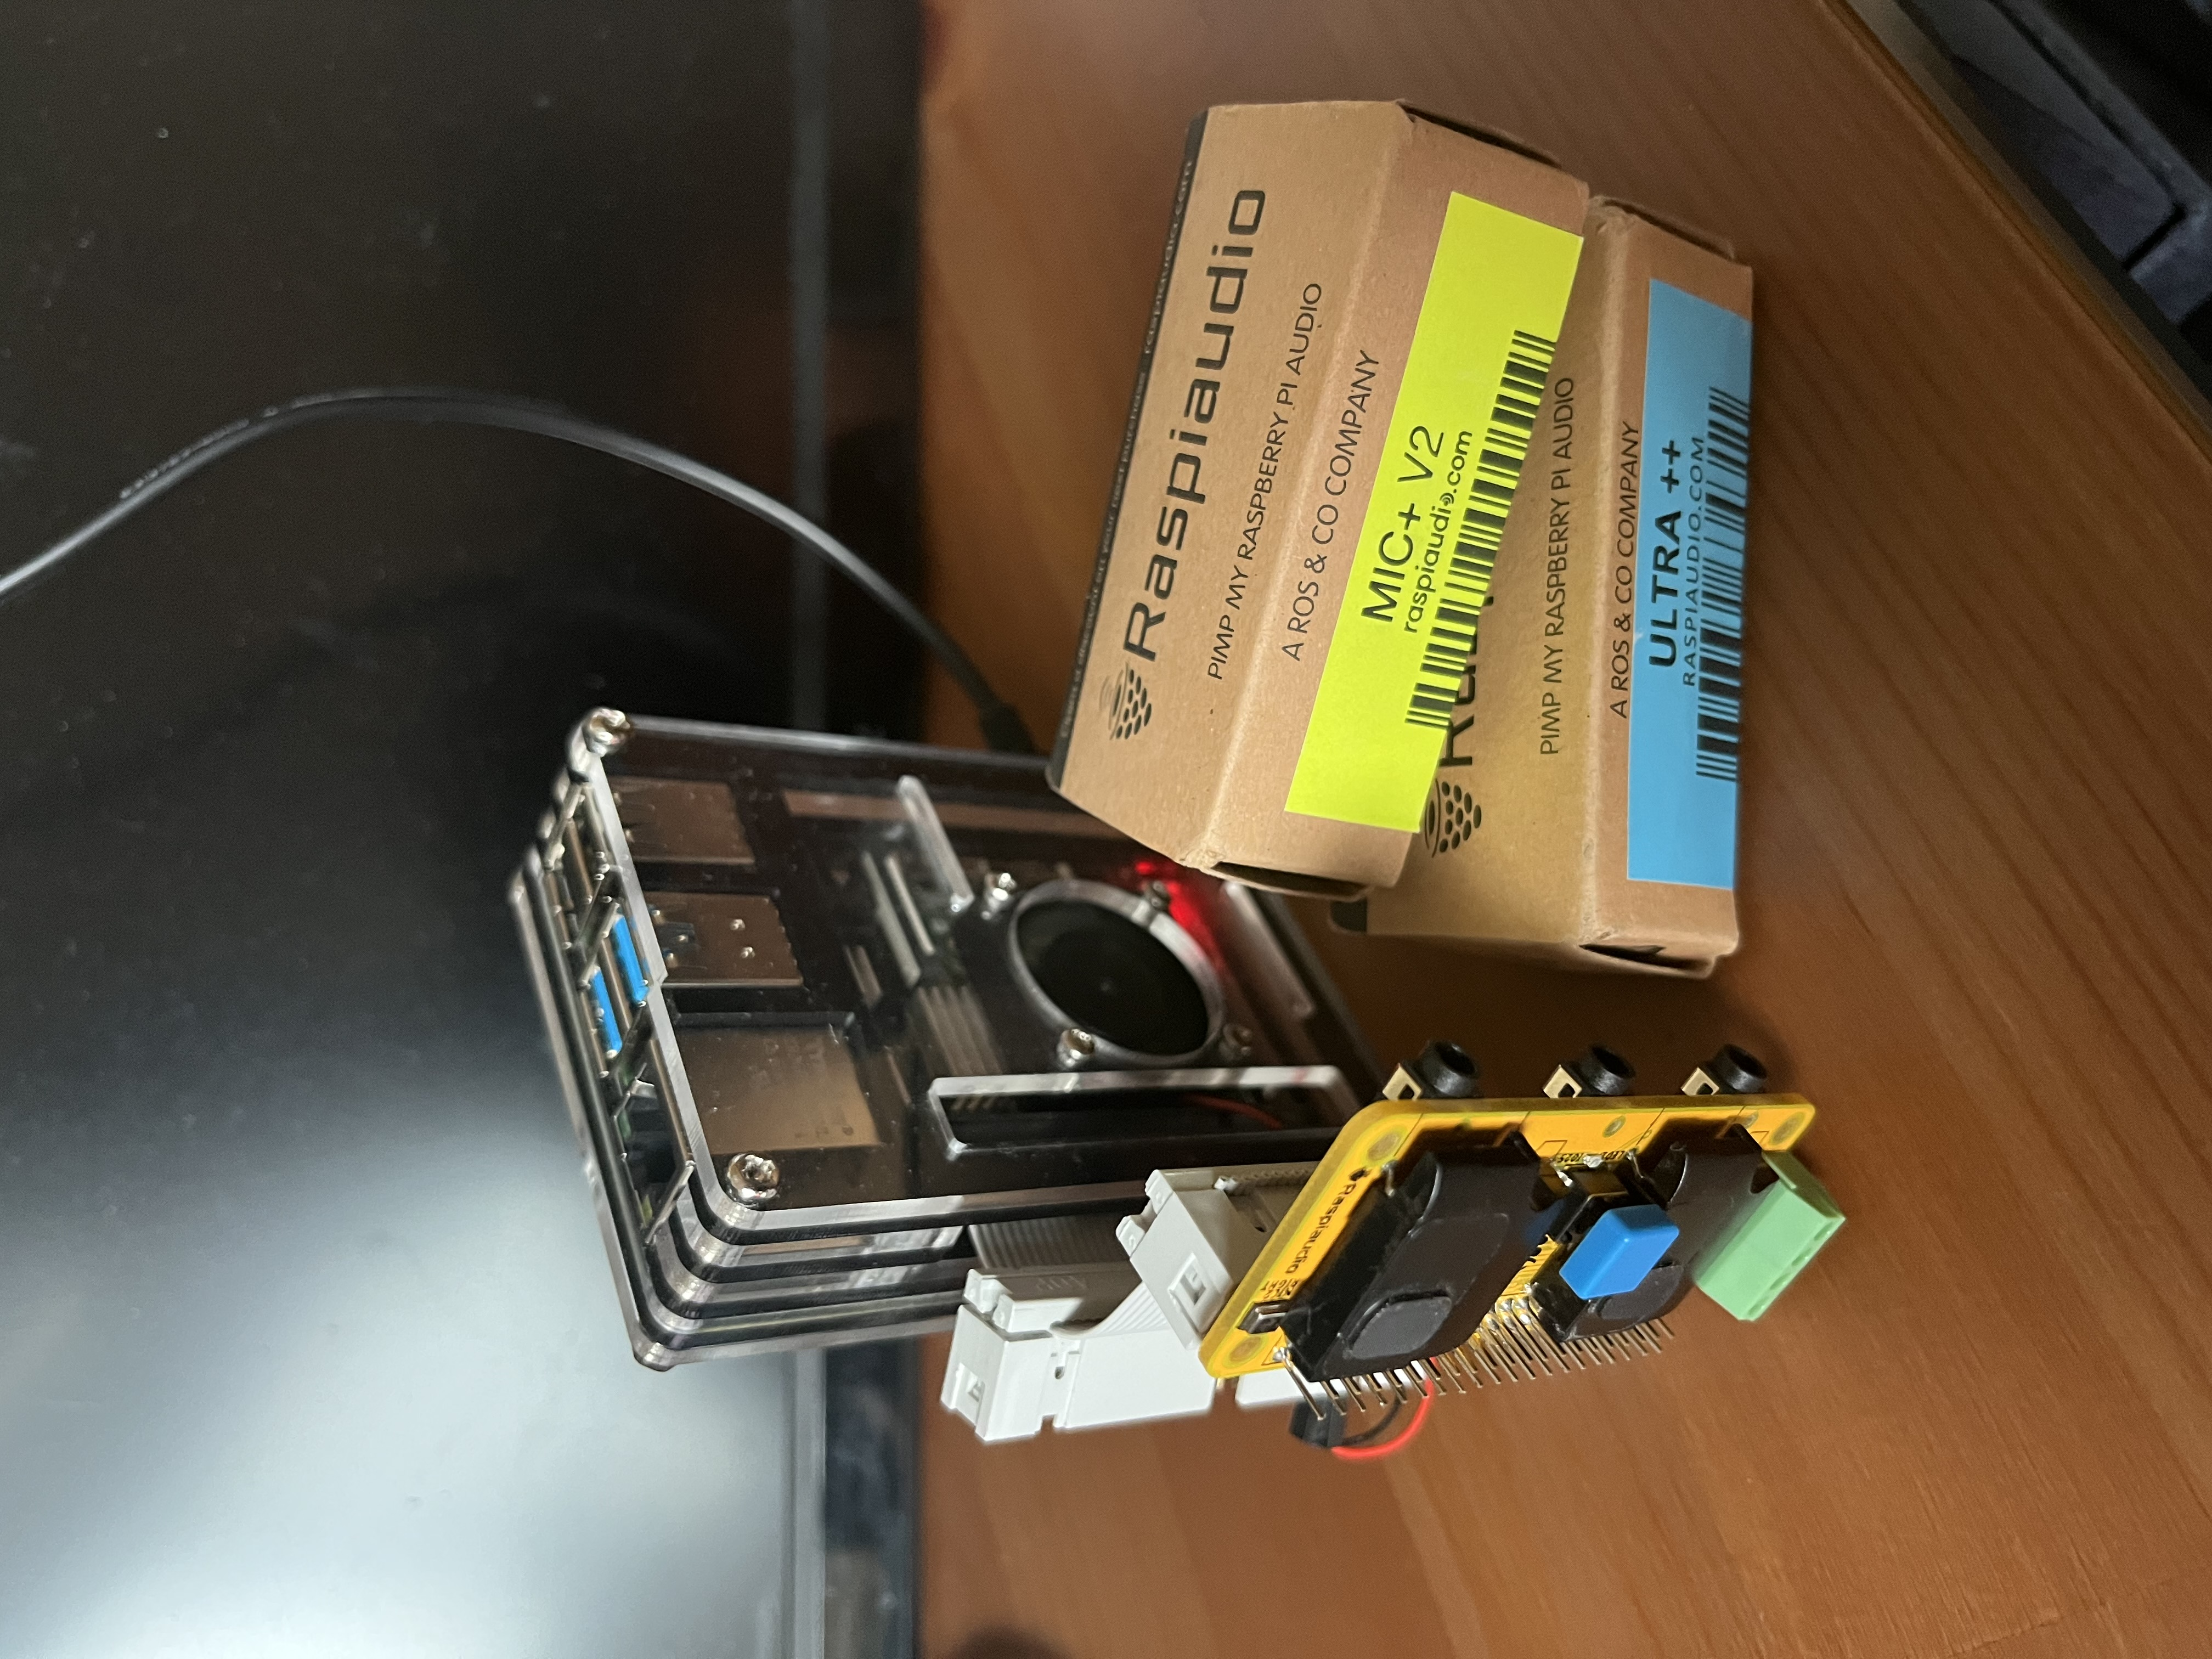
Rasbperry Pi running inference with attached (but not functional) sound board.

## Conclusion: Returning to language detection

After building the model several lessons were taken:

* The Speech Commands model compressed into the Rasbperry Pi very easily. Should attempte the larger label matrix of the language dataset with the CNN model. The CNN model will need changing in order to handle a sequence of events.
* Most audio models leverage spectrograms or other image renditions of audio data, but the M5 model shows an interesting approach to achieving the same results in the neural network from raw data.
* OpenCV may not be available, but ONNX presents an interesting approach to migrating the model data to a C++ app without having to hard code the model data into a header file.
* Data collection is actually complex. Several test samples recorded for testing would not infer correctly, until after the audio was clipped to the correct length. It is natural behavior to click a button, and wait a second before speaking and clicking again. Most test samples recorded manually for testing were 3 to 5 seconds long, but a 16000KHz 16000 sample file is only one second long. This requires tooling to implement in an actual model implementation.
* Considering this is my first study of neural networks, and pytorch modeling, this learning experience showed that
embedded networks are not entirely unnaproachable. In fact, once enough tools are understood, it is very reasonable to expect to implement inference models in embedded applications.

# CNN Model

The following sections outline the training and model design

In [1]:
import IPython as ipd
import librosa
from utils import *

import torch
import torch.nn
import torch.optim
from torch.utils.data import IterableDataset
from torchinfo import summary

from collections import OrderedDict

import os
import timeit
from time import time

import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DEVICE = "cpu"
if torch.cuda.is_available():
    DEVICE = "cuda"

print(f"USING DEVICE {DEVICE}")

USING DEVICE cuda


## Preview the speech data

In [3]:
# Define source paths. Place data under working directory and name folder "voicedata"
DATA_DIR = "./commands"
TARGET_RATE = 8000
EPOCHS = 10
os.makedirs(DATA_DIR, exist_ok=True)
train_set = SpeechCommandsSubset(root=DATA_DIR, download=True, rate=TARGET_RATE)
test_set = SpeechCommandsSubset(root=DATA_DIR, download=True, subset="testing", rate=TARGET_RATE)
validate_set = SpeechCommandsSubset(root=DATA_DIR, download=True, subset="validation", rate=TARGET_RATE)

# labels = sorted(list(set(datapoint[2] for datapoint in train_set)))
labels = train_set.labels

print(f'  Training Set: {len(train_set)}')
print(f'   Testing Set: {len(test_set)}')
print(f'Validation Set: {len(validate_set)}')

print(f'   Data Labels: {len(labels)}')

  Training Set: 84843
   Testing Set: 11005
Validation Set: 9981
   Data Labels: 35


In [4]:
print(labels)

['backward', 'bed', 'bird', 'cat', 'dog', 'down', 'eight', 'five', 'follow', 'forward', 'four', 'go', 'happy', 'house', 'learn', 'left', 'marvin', 'nine', 'no', 'off', 'on', 'one', 'right', 'seven', 'sheila', 'six', 'stop', 'three', 'tree', 'two', 'up', 'visual', 'wow', 'yes', 'zero']


In [5]:
waveform, rate, label, speaker, id = train_set[52000]
print(f"Label: {label} ({label_to_index(label, labels)})")
print(rate)
print(waveform.size())
ipd.display.Audio(data=waveform, rate=rate)

Label: right (22)
8000
torch.Size([1, 8000])


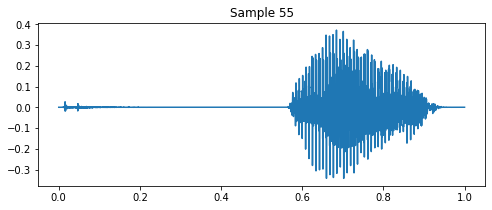

In [6]:
Y = waveform.view(-1).numpy()
times = np.linspace(0, len(Y) / rate, len(Y))
plot(times, Y, title="Sample 55")

While interesting to see the spectrogram, the M5 model does not use spectrograms, and instead achieves the same result by model depth.

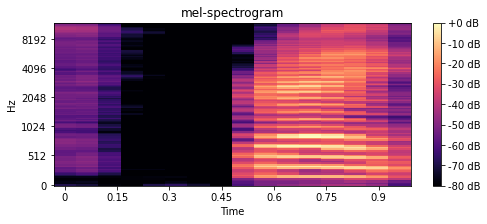

In [7]:
spectrogram = librosa.feature.melspectrogram(y=waveform.view(-1).numpy(), sr=rate)
plot_spectro(spectrogram, rate)

# Experiment with M5
As discussed above, implement, train and evaluate the M5 model.

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class M5(nn.Module):
    def __init__(self, n_input=1, n_output=35, stride=16, n_channel=32):
        super().__init__()
        # print("INIT M5: ", n_input, n_output, stride, n_channel)
        self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
        self.bn1 = nn.BatchNorm1d(n_channel)
        self.pool1 = nn.MaxPool1d(4)
        self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(n_channel)
        self.pool2 = nn.MaxPool1d(4)
        self.conv3 = nn.Conv1d(n_channel, 2 * n_channel, kernel_size=3)
        self.bn3 = nn.BatchNorm1d(2 * n_channel)
        self.pool3 = nn.MaxPool1d(4)
        self.conv4 = nn.Conv1d(2 * n_channel, 2 * n_channel, kernel_size=3)
        self.bn4 = nn.BatchNorm1d(2 * n_channel)
        self.pool4 = nn.MaxPool1d(4)
        self.fc1 = nn.Linear(2 * n_channel, n_output)
        
        # self.rendered = False
        
    def forward(self, x):
        # if self.rendered: print("\ninput: ", x.shape)
        x = self.conv1(x)
        # if self.rendered: print("1 : conv: ", x.shape)
        x = F.relu(self.bn1(x))
        # if self.rendered: print("1 : relu: ", x.shape)
        x = self.pool1(x)
        # if self.rendered: print("1 : pool: ", x.shape)
        x = self.conv2(x)
        # if self.rendered: print("2 : conv: ", x.shape)
        x = F.relu(self.bn2(x))
        # if self.rendered: print("2 : relu: ", x.shape)
        x = self.pool2(x)
        # if self.rendered: print("2 : pool: ", x.shape)
        x = self.conv3(x)
        # if self.rendered: print("3 : conv: ", x.shape)
        x = F.relu(self.bn3(x))
        # if self.rendered: print("3 : relu: ", x.shape)
        x = self.pool3(x)
        # if self.rendered: print("3 : pool: ", x.shape)
        x = self.conv4(x)
        # if self.rendered: print("4 : conv: ", x.shape)
        x = F.relu(self.bn4(x))
        # if self.rendered: print("4 : relu: ", x.shape)
        x = self.pool4(x)
        # if self.rendered: print("4 : pool: ", x.shape)
        x = F.avg_pool1d(x, (1))
        # if self.rendered: print("out : avgpool: ", x.shape)
        x = x.permute(0, 2, 1)
        # if self.rendered: print("out : permute: ", x.shape)
        x = self.fc1(x)
        # if self.rendered: print("out: ", x.shape)
        
        # if (self.rendered): self.rendered = False
        return F.log_softmax(x, dim=2)

In [9]:
BATCH_SIZE = 24
LEARNING_RATE = 0.003
DEF_CAP=None
DEF_EPOCHS=10

def initialize_model(hidden_size, fn=None, learning_rate=LEARNING_RATE, stride=16, n_channel=32):
    """Instantiate the M5 model"""
    model = M5(n_input=1, n_output=hidden_size, stride=stride, n_channel=n_channel)
    model = model.to(DEVICE)

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    if not fn:
        loss_fn = torch.nn.CrossEntropyLoss()
    else:
        loss_fn = fn
    
    return model, optimizer, loss_fn

In [10]:
def init_loader(target_rate, batch_size, subset=None):
    """Configure a dataloader for training, validation or testing sets at target_rate"""
    dataset = SpeechCommandsSubset(
        root=DATA_DIR,
        download=True,
        subset=subset,
        rate=target_rate
    )

    num_workers = 0 if DEVICE=="cpu" else 4
    pin_memory = False if DEVICE=="cpu" else True

    data_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=pin_memory
    )
    
    return data_loader

In [11]:
def train_model(model, optimizer, loss_fn, train_data, labels, epochs=1, cap=None):
    """Train the model collecting time and loss information"""
    model.train()
    
    loss_summary = 0
    data_size = 0
    losses = []
    micro_time = 0

    for e in range(epochs):
        print(f" {e} ", end="|")
        
        count = 0.0
        for waveform, rate, label, speaker, id in train_data:
            if cap and count > cap:
                break
            count += 1

            # Initialize gradients
            optimizer.zero_grad()
            
            # Prep waveform and target data
            target = torch.tensor([label_to_index(x, labels) for x in label])
            waveform = waveform.to(DEVICE)
            target = target.to(DEVICE)

            # Infer model
            before = time()
            output = model(waveform)

            # Calculate loss
            batch_len = waveform.shape[0]
            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item() * batch_len
            data_size += batch_len

            # Optimize
            loss.backward()
            optimizer.step()

            micro_time += time() - before

        losses.append(loss_summary / data_size)
    print(f"train time: {micro_time:.3f} seconds")
    return losses

In [12]:
def eval_model(model, loss_fn, test_data, cap=3):
    with torch.no_grad():
        model.eval()
        loss_summary = 0
        data_size = 0
        attempts = 0
        hits = 0

        count = 0
        for waveform, rate, label, speaker, id in test_data:
            if cap and count > cap:
                break
            count += 1

            # send data to target device
            waveform = waveform.to(DEVICE)
            target = torch.tensor([label_to_index(x, labels) for x in label])
            target = target.to(DEVICE)
            batch_len = waveform.shape[0]

            # Predict, calculate loss, calculate gradients
            output = model(waveform)

            loss = loss_fn(output.view(batch_len, -1), target)
            loss_summary += loss.item()
            data_size += batch_len
            
            prediction = torch.argmax(output.view(batch_len, -1), dim=1)
            hits += prediction[prediction == target].shape[0]
            attempts += prediction.shape[0]
            # print(prediction == target)
            # print(prediction[prediction == target])

        loss_summary = loss_summary / data_size
        return model, loss_summary, attempts, hits

In [13]:
losses = []
times = []
accuracies = []
correct = []

# init_loader(target_rate, batch_size, subset=None)
# initialize_model(hidden_size, fn=None, learning_rate=LEARNING_RATE, stride=8, n_channel=16)
# train_model(model, optimizer, loss_fn, train_data, labels, epochs=1, cap=None)
# eval_model(model, loss_fn, test_data, cap=3)
    
def timed_training(
    rate=TARGET_RATE,
    batch_size=24,
    fn=None,
    lr=0.003,
    stride=16,
    n_channel=32,
    cap=DEF_CAP,
    ep=DEF_EPOCHS
):
    print(f"Training: {rate} Khz batch={batch_size} lr={lr:.3f} stride={stride} chan={n_channel}")
    # Configure the data loaders
    train_data = init_loader(rate, batch_size, "training")
    test_data = init_loader(rate, batch_size, "testing")

    # configure the model and optimizer
    m, o, l = initialize_model(len(labels), fn=fn, learning_rate=lr, stride=stride, n_channel=n_channel)

    # Train the model
    start_time = time()
    losses.append(train_model(m, o, l, train_data, labels, epochs=ep, cap=cap))
    result = time() - start_time
    print(f"== Training time: {result:.3f} seconds")
    times.append(result)
    
    # Evaluate the model
    m, loss, attempts, hits = eval_model(m, l, test_data, cap=cap)
    accuracies.append(hits/attempts)
    correct.append(hits)
    
    return m


## Basic Model information
Run the model at a few stride and channel combinations to calculate the model shape. After training the model with with the standard configuration, experiments will show how much accuracy degrades by removing some of these channel parameters.

The results show significant parameter savings by reducing the configuration:

| Rate    | stride  | channel | parameters |
|---------|---------|---------|:----------:|
|    2000 |       4 |       8 |       2723 |
|    2000 |       4 |      32 |      26915 |
|    4000 |       8 |      16 |       8099 |
|    4000 |       8 |      32 |      26915 |
|    8000 |      16 |       8 |       2723 |
|    8000 |      16 |      32 |      26915 |

While on a desktop computer, these differences won't seem significant, on a MCU, these could be significant savings.

In [14]:
losses = []
times = []
accuracies = []
correct = []

tests = [
    (2000, 4, 8), # Min rate, min learning
    (2000, 4, 32), # Min rate, max learning
    (4000, 8, 8), # mid rate, min learning
    (4000, 8, 32), # mid rate, max learning
    (8000, 16, 8), # normal rate, min learning
    (8000, 16, 32), # normal rate, max learning
]
# Very quick data test to see entire functionality
models = [timed_training(rate=r, cap=10, ep=1, stride=s, n_channel=c) for r, s, c in tests]
stats = [summary(m, (1, 1, r)) for m, (r, s, c) in zip(models, tests)]

print("Losses: ", losses)
print("Times: ", times)
print("Accuracies: ", accuracies)
print("Correct results:", correct)

Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=8
 0 |train time: 0.045 seconds
== Training time: 0.300 seconds
Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=32
 0 |train time: 0.035 seconds
== Training time: 0.262 seconds
Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=8
 0 |train time: 0.037 seconds
== Training time: 0.270 seconds
Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=32
 0 |train time: 0.031 seconds
== Training time: 0.272 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=16 chan=8
 0 |train time: 0.045 seconds
== Training time: 0.269 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=16 chan=32
 0 |train time: 0.036 seconds
== Training time: 0.266 seconds
Losses:  [[3.6173076846382837], [3.725896640257402], [3.7037104693326084], [3.6861025636846367], [3.8101894855499268], [3.6444218158721924]]
Times:  [0.29951000213623047, 0.26227235794067383, 0.2697715759277344, 0.27162909507751465, 0.2686169147491455, 0.26595115661621094]
Accuracies:  [0.034090909090909

In [15]:
print("| Rate    | stride  | channel | parameters |")
print("|---------|---------|---------|:----------:|")
for s, (r, st, ch) in zip(stats, tests):
    s = [x for x in str(s).split("\n") if "Total params:" in x]
    s = [int("".join(x.split(":")[1].strip().split(","))) for x in s]
    print(f"|{r:8d} |{st:8d} |{ch:8d} |{s[0]:11d} |")
    
    

| Rate    | stride  | channel | parameters |
|---------|---------|---------|:----------:|
|    2000 |       4 |       8 |       2723 |
|    2000 |       4 |      32 |      26915 |
|    4000 |       8 |       8 |       2723 |
|    4000 |       8 |      32 |      26915 |
|    8000 |      16 |       8 |       2723 |
|    8000 |      16 |      32 |      26915 |


In [16]:
for s, (r, st, ch) in zip(stats, tests):
    s = [x for x in str(s).split("\n") if "Total params:" in x]
    s = [int("".join(x.split(":")[1].strip().split(","))) for x in s]
    print(f"({r}, {st}, {ch}),")

(2000, 4, 8),
(2000, 4, 32),
(4000, 8, 8),
(4000, 8, 32),
(8000, 16, 8),
(8000, 16, 32),


# Explore Model Parameters

Follow these steps to configure the model:

* Find a learning rate
* Explore impact of stride/channel
* Explore impact of audio sample rate

## Find a learning rate
Look for a reasonable learning rate, starting with the documented stride and channels.

The following sample output shows that a learning rate of 0.003 should yield acceptable accuracy for the model.

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|  0.001 |   0.802 |  81.845% |152.689 |
|  0.003 |   0.788 |  81.745% |153.042 |
|  0.005 |   0.797 |  82.008% |152.919 |
|  0.007 |   0.833 |  80.954% |153.465 |
|  0.010 |   0.872 |  81.499% |153.392 |
|  0.030 |   1.235 |  71.722% |152.031 |
|  0.050 |   2.583 |  25.906% |151.155 |

In [17]:
losses = []
times = []
accuracies = []
correct = []

# Test various learning rates against the whole data set
rates = [0.001, 0.003, 0.005, 0.007, 0.01, 0.03, 0.05]
models = [timed_training(rate=8000, lr=lr, cap=DEF_CAP, ep=DEF_EPOCHS, stride=16, n_channel=32) for lr in rates]


Training: 8000 Khz batch=24 lr=0.001 stride=16 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 107.043 seconds
== Training time: 149.650 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=16 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 105.626 seconds
== Training time: 148.478 seconds
Training: 8000 Khz batch=24 lr=0.005 stride=16 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 105.206 seconds
== Training time: 149.628 seconds
Training: 8000 Khz batch=24 lr=0.007 stride=16 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 108.288 seconds
== Training time: 150.819 seconds
Training: 8000 Khz batch=24 lr=0.010 stride=16 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 108.606 seconds
== Training time: 150.604 seconds
Training: 8000 Khz batch=24 lr=0.030 stride=16 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 107.592 seconds
== Training time: 150.482 seconds
Training: 8000 Khz batch=24 lr=0.050 stride=16 chan=32
 0 

Results per learning rate

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|  0.001 |   0.799 |  82.644% |149.650 |
|  0.003 |   0.777 |  81.209% |148.478 |
|  0.005 |   0.815 |  80.336% |149.628 |
|  0.007 |   0.834 |  79.791% |150.819 |
|  0.010 |   0.896 |  78.083% |150.604 |
|  0.030 |   1.472 |  64.471% |150.482 |
|  0.050 |   2.543 |  28.887% |150.122 |


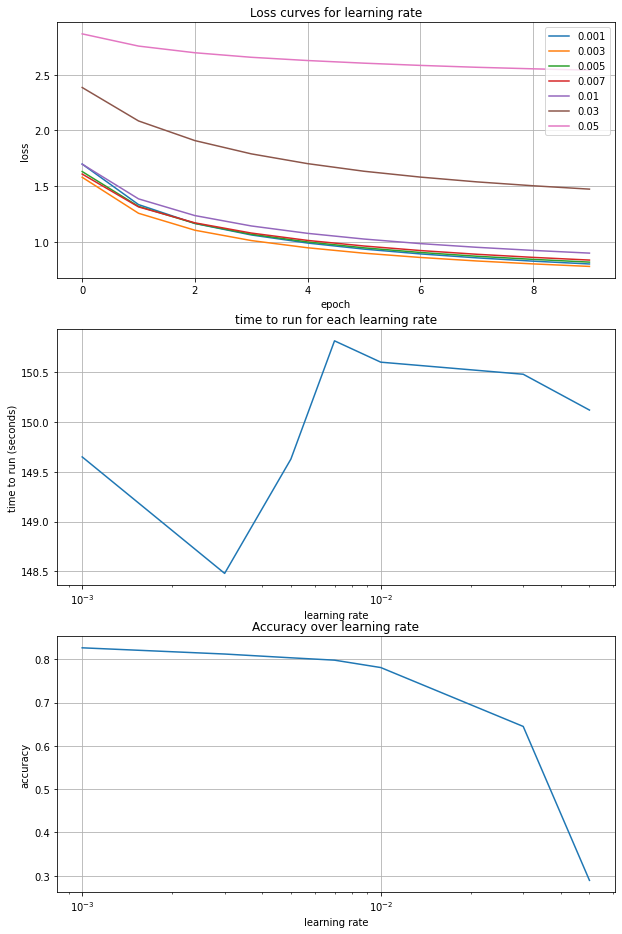

In [18]:
print_results(rates, "learning rate", times, losses, accuracies, DEF_EPOCHS)
plot_results(rates, "learning rate", times, losses, accuracies, DEF_EPOCHS)

## Explore Impact of model configuration

Set the learning rate to 0.003 and use samples of 8000 KHz to see the impact of lowering the stride and channel.
From the results for learning rate, use only 4 epochs to compare, as the model should start converging around this time.

In [19]:
losses = []
times = []
accuracies = []
correct = []

# Test minimum learning config for each data rate capacity
tests = [
    (2000, 4, 8),
    (4000, 8, 8),
    (8000, 16, 8),
]
models = [
    timed_training(
        rate=8000,
        lr=0.003,
        cap=DEF_CAP,
        ep=4,
        stride=s,
        n_channel=c
    ) for _, s, c in tests
]

Training: 8000 Khz batch=24 lr=0.003 stride=4 chan=8
 0 | 1 | 2 | 3 |train time: 42.450 seconds
== Training time: 59.780 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=8 chan=8
 0 | 1 | 2 | 3 |train time: 41.566 seconds
== Training time: 59.553 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=16 chan=8
 0 | 1 | 2 | 3 |train time: 42.588 seconds
== Training time: 59.917 seconds


Results per audio rate

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|2000.000 |   5.219 |   3.826% | 59.780 |
|4000.000 |   3.782 |  18.019% | 59.553 |
|8000.000 |   1.878 |  51.177% | 59.917 |


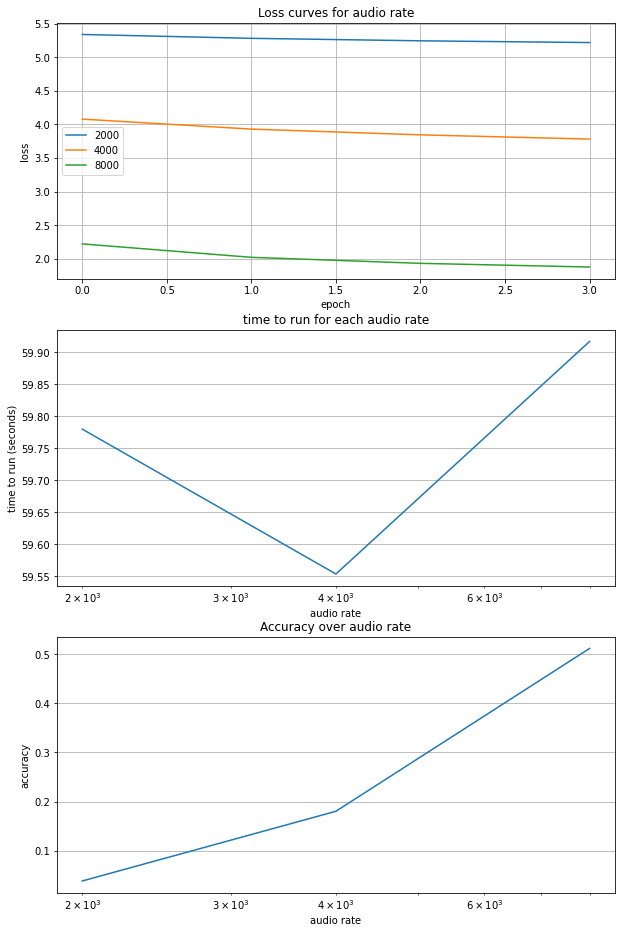

In [20]:
param_sizes = [ps for ps, _, _ in tests]
print_results(param_sizes, "audio rate", times, losses, accuracies, 4)
plot_results(param_sizes, "audio rate", times, losses, accuracies, 4)

In [21]:
losses = []
times = []
accuracies = []
correct = []

# Test maximum learning config for each data rate capacity
tests = [
    (2000, 4, 32),
    (4000, 8, 32),
    (8000, 16, 32),
]
models = [
    timed_training(
        rate=8000,
        lr=0.003,
        cap=DEF_CAP,
        ep=4,
        stride=s,
        n_channel=c
    ) for _, s, c in tests
]

Training: 8000 Khz batch=24 lr=0.003 stride=4 chan=32
 0 | 1 | 2 | 3 |train time: 42.211 seconds
== Training time: 60.119 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=8 chan=32
 0 | 1 | 2 | 3 |train time: 43.329 seconds
== Training time: 59.890 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=16 chan=32
 0 | 1 | 2 | 3 |train time: 45.423 seconds
== Training time: 61.490 seconds


Results per audio rate

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|2000.000 |   5.111 |   5.252% | 60.119 |
|4000.000 |   3.351 |  26.415% | 59.890 |
|8000.000 |   1.026 |  77.974% | 61.490 |


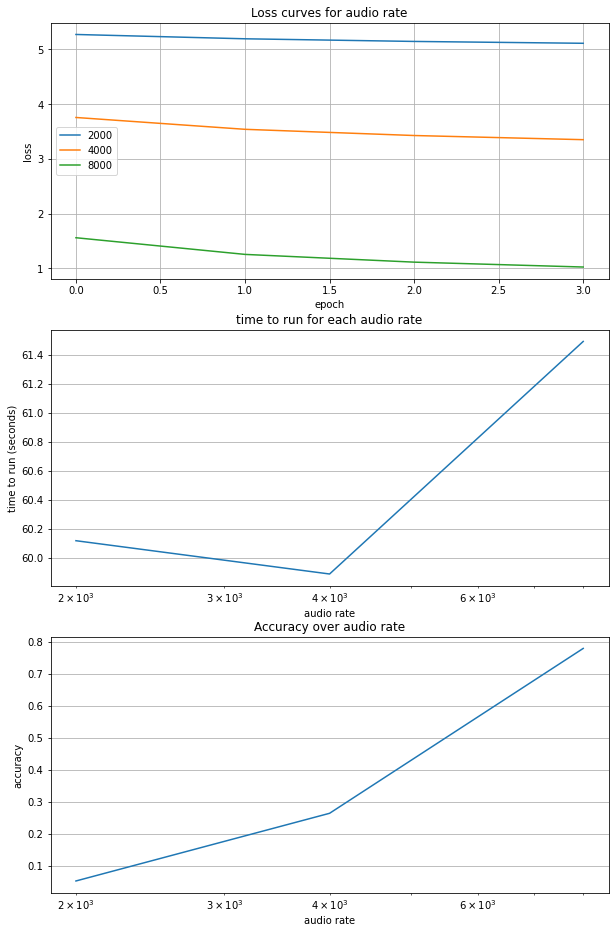

In [22]:
param_sizes = [ps for ps, _, _ in tests]
print_results(param_sizes, "audio rate", times, losses, accuracies, 4)
plot_results(param_sizes, "audio rate", times, losses, accuracies, 4)

The results above show that a stride of 16 and 32 channels are necessary for the model to learn something with 8000 Khz input data. Could this change by varying the input samples?

## Explore impact of audio sample rate

Varying the stride without adjusting the input rate doesn't yield improved learning. As a last attempt at reducing consumption, try the model again, this time reducing the stride to match the input rate.

In [23]:
losses = []
times = []
accuracies = []
correct = []

# Test maximum learning config for each data rate capacity
tests = [
    (2000, 4, 32),
    (4000, 8, 32),
    (8000, 16, 32),
]
models = [
    timed_training(
        rate=r,
        lr=0.003,
        cap=DEF_CAP,
        ep=4,
        stride=s,
        n_channel=c
    ) for r, s, c in tests
]

Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=32
 0 | 1 | 2 | 3 |train time: 42.424 seconds
== Training time: 58.919 seconds
Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=32
 0 | 1 | 2 | 3 |train time: 43.918 seconds
== Training time: 59.572 seconds
Training: 8000 Khz batch=24 lr=0.003 stride=16 chan=32
 0 | 1 | 2 | 3 |train time: 44.186 seconds
== Training time: 60.489 seconds


Results per audio rate

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|2000.000 |   1.413 |  61.690% | 58.919 |
|4000.000 |   1.186 |  74.003% | 59.572 |
|8000.000 |   1.015 |  77.365% | 60.489 |


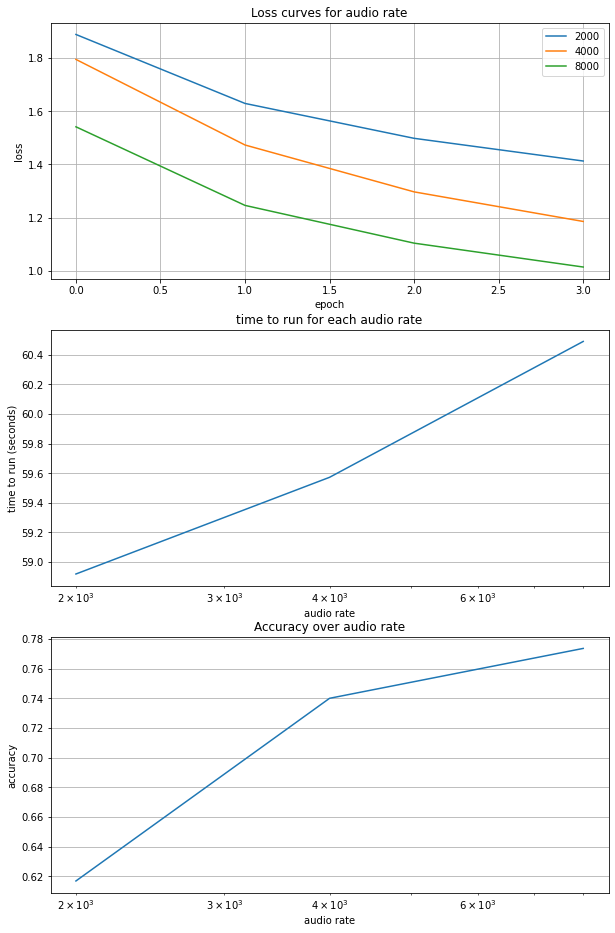

In [24]:
param_sizes = [ps for ps, _, _ in tests]
print_results(param_sizes, "audio rate", times, losses, accuracies, 4)
plot_results(param_sizes, "audio rate", times, losses, accuracies, 4)

### Try to minimize size
Matching the input rate to the stride had a huge impact on results. Now try to vary learning capacity by reducing the channels.

In [25]:
losses = []
times = []
accuracies = []
correct = []

# Test maximum learning config for each data rate capacity
tests = [
    (2000, 4, 8),
    (2000, 4, 16),
    (2000, 4, 24),
    (2000, 4, 32),
]
models = [
    timed_training(
        rate=r,
        lr=0.003,
        cap=DEF_CAP,
        ep=DEF_EPOCHS,
        stride=s,
        n_channel=c
    ) for r, s, c in tests
]

Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=8
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 104.417 seconds
== Training time: 146.575 seconds
Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=16
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 101.902 seconds
== Training time: 145.534 seconds
Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=24
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 101.681 seconds
== Training time: 145.130 seconds
Training: 2000 Khz batch=24 lr=0.003 stride=4 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 103.234 seconds
== Training time: 145.362 seconds


Results per channel count

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|  8.000 |   1.768 |  53.857% |146.575 |
| 16.000 |   1.436 |  61.499% |145.534 |
| 24.000 |   1.284 |  66.324% |145.130 |
| 32.000 |   1.183 |  68.741% |145.362 |


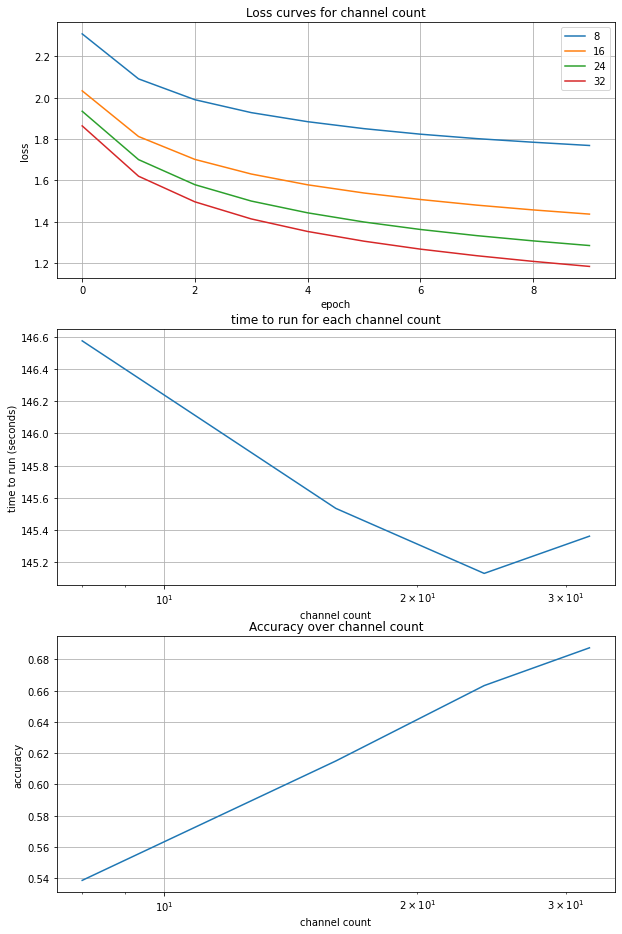

In [26]:
param_sizes = [c for ps, _, c in tests]
print_results(param_sizes, "channel count", times, losses, accuracies, DEF_EPOCHS)
plot_results(param_sizes, "channel count", times, losses, accuracies, DEF_EPOCHS)

It seems unlikely to make a good prediction with 2000 KHz audio. Try 4000 KHz next.

In [27]:
losses = []
times = []
accuracies = []
correct = []

# Test maximum learning config for each data rate capacity
tests = [
    (4000, 8, 8),
    (4000, 8, 16),
    (4000, 8, 24),
    (4000, 8, 32),
]
models = [
    timed_training(
        rate=r,
        lr=0.003,
        cap=DEF_CAP,
        ep=DEF_EPOCHS,
        stride=s,
        n_channel=c
    ) for r, s, c in tests
]

Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=8
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 105.077 seconds
== Training time: 147.309 seconds
Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=16
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 105.669 seconds
== Training time: 146.732 seconds
Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=24
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 106.187 seconds
== Training time: 147.566 seconds
Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=32
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 |train time: 106.957 seconds
== Training time: 146.090 seconds


Results per channel count

|        | Loss    | Accuracy | Time   |
|--------|---------|----------|--------|
|  8.000 |   1.752 |  52.740% |147.309 |
| 16.000 |   1.226 |  73.085% |146.732 |
| 24.000 |   1.053 |  74.730% |147.566 |
| 32.000 |   0.938 |  80.282% |146.090 |


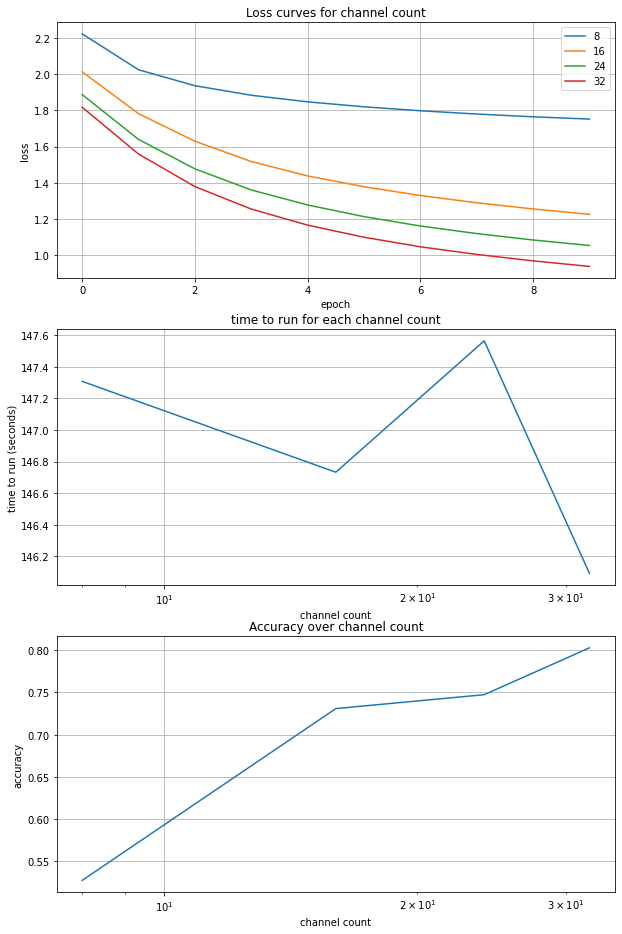

In [28]:
param_sizes = [c for ps, _, c in tests]
print_results(param_sizes, "channel count", times, losses, accuracies, DEF_EPOCHS)
plot_results(param_sizes, "channel count", times, losses, accuracies, DEF_EPOCHS)

With 4000 KHz, and 24 channels, it seems feasible that the accuracy may reach over 75% which may be good enough for our target application. Train that model with more epochs to see the results.

In [29]:
losses = []
times = []
accuracies = []
correct = []

model = timed_training(
        rate=4000,
        lr=0.003,
        cap=DEF_CAP,
        ep=30,
        stride=8,
        n_channel=24
    ) 

print("Accuracy: ", accuracies[0])

Training: 4000 Khz batch=24 lr=0.003 stride=8 chan=24
 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 | 21 | 22 | 23 | 24 | 25 | 26 | 27 | 28 | 29 |train time: 319.043 seconds
== Training time: 447.889 seconds
Accuracy:  0.7809177646524307


# Save the model

In [30]:
print(model)

M5(
  (conv1): Conv1d(1, 24, kernel_size=(80,), stride=(8,))
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv1d(24, 24, kernel_size=(3,), stride=(1,))
  (bn2): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv1d(24, 48, kernel_size=(3,), stride=(1,))
  (bn3): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv1d(48, 48, kernel_size=(3,), stride=(1,))
  (bn4): BatchNorm1d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=48, out_features=35, bias=True)
)


In [31]:
summary(model)

Layer (type:depth-idx)                   Param #
M5                                       --
├─Conv1d: 1-1                            1,944
├─BatchNorm1d: 1-2                       48
├─MaxPool1d: 1-3                         --
├─Conv1d: 1-4                            1,752
├─BatchNorm1d: 1-5                       48
├─MaxPool1d: 1-6                         --
├─Conv1d: 1-7                            3,504
├─BatchNorm1d: 1-8                       96
├─MaxPool1d: 1-9                         --
├─Conv1d: 1-10                           6,960
├─BatchNorm1d: 1-11                      96
├─MaxPool1d: 1-12                        --
├─Linear: 1-13                           1,715
Total params: 16,163
Trainable params: 16,163
Non-trainable params: 0

In [32]:
torch.save(model.state_dict(), "data/model_info.json", _use_new_zipfile_serialization=False)

In [33]:
import json
for p in model.named_parameters():
    value = p[1].cpu().detach().numpy()
    print(p[0])
    with open(f"data/model_{p[0]}.json", "w") as f:
        json.dump(value.tolist(), f, indent=4)
    with open(f"data/model_{p[0]}.info", "w") as f:
        json.dump(p[1].shape, f, indent=4)

conv1.weight
conv1.bias
bn1.weight
bn1.bias
conv2.weight
conv2.bias
bn2.weight
bn2.bias
conv3.weight
conv3.bias
bn3.weight
bn3.bias
conv4.weight
conv4.bias
bn4.weight
bn4.bias
fc1.weight
fc1.bias


In [34]:
test_data = init_loader(4000, 24, "testing")
lossfn = torch.nn.CrossEntropyLoss()
m, loss, attempts, hits = eval_model(model, lossfn, test_data, cap=None)
accuracies.append(hits/attempts)
print(accuracies)

[0.7809177646524307, 0.7809177646524307]


# Quantize the model

## Zero out smallest parameters

In [35]:
def zero_clamp(t, level):
    z = torch.zeros_like(t)
    o = torch.ones_like(t)
    changes = torch.where(torch.abs(t) > level,z, o)
    changes = torch.sum(changes)
    return torch.where(torch.abs(t) > level, t, z), changes

def clamp_model(model, level):
    with torch.no_grad():
        new_params = OrderedDict()
        old_params = model.state_dict()
        changed = torch.tensor(0.0).to(DEVICE)

        for k, v in old_params.items():
            new_params[k], changes = zero_clamp(v, level)
            changed += changes

        model.load_state_dict(new_params)
        return changed

clamp_model(model, 0.01)

tensor(157., device='cuda:0')

In [36]:
m, loss, attempts, hits = eval_model(model, lossfn, test_data, cap=None)
accuracies.append(hits/attempts)
print(accuracies)

[0.7809177646524307, 0.7809177646524307, 0.7809177646524307]


In [37]:
# Reload the model from trained file
model, optimizer, lossfn = initialize_model(len(labels), fn=lossfn, learning_rate=0.003, stride=8, n_channel=24)
model.load_state_dict(torch.load("data/model_info.json"))

<All keys matched successfully>

In [38]:
# Confirm model behaves as expected
accuracies = []
m, loss, attempts, hits = eval_model(model, lossfn, test_data, cap=None)
accuracies.append(hits/attempts)
print(accuracies)

[0.7809177646524307]


In [39]:
# Evaluate the clamped model at different clamp values
accuracies = []
clamps = [0, 0.001, 0.005, 0.01, 0.015, .02, 0.025, 0.03, 0.035, 0.04, 0.045, 0.05]
changes = []
for c in clamps:
    changes.append(clamp_model(model, c))
    m, loss, attempts, hits = eval_model(model, lossfn, test_data, cap=None)
    accuracies.append(hits/attempts)
    
changes = [x.cpu().item() for x in changes]

In [40]:
print("| clamp | accuracy | changes |")
print("|-------|----------|---------|")
for c,a,d in zip(clamps, accuracies, changes):
    print(f"|{c:.3f}|{a*100:.3f}|{d}|")


| clamp | accuracy | changes |
|-------|----------|---------|
|0.000|78.092|0.0|
|0.001|78.092|13.0|
|0.005|78.101|71.0|
|0.010|78.092|157.0|
|0.015|78.110|244.0|
|0.020|78.364|311.0|
|0.025|78.310|381.0|
|0.030|78.264|460.0|
|0.035|78.292|542.0|
|0.040|4.671|616.0|
|0.045|4.698|687.0|
|0.050|4.543|770.0|


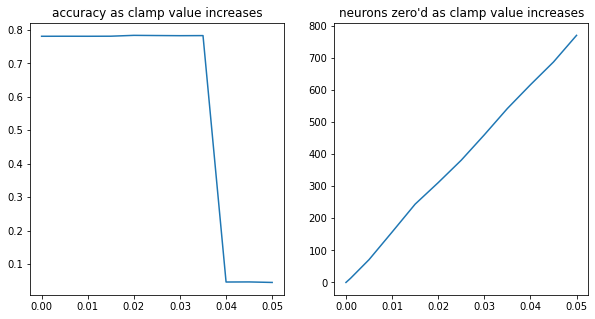

In [41]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
plot(clamps, accuracies, ax=ax[0], title="accuracy as clamp value increases")
plot(clamps, changes, ax=ax[1], title="neurons zero'd as clamp value increases")

In [59]:
542/16163 * 100

3.353337870444843

There is only a 3.4% reduction in parameters by clamping, however, we'll use this as well to help quantize the model.

# Validate the results of the model against the validation set

In [60]:
accuracies=[]
model.load_state_dict(torch.load("data/model_info.json"))
m, loss, attempts, hits = eval_model(model, lossfn, test_data, cap=None)
accuracies.append(hits/attempts)

clamp_model(model, 0.035)
m, loss, attempts, hits = eval_model(model, lossfn, test_data, cap=None)
accuracies.append(hits/attempts)

print(accuracies)

[0.7809177646524307, 0.7829168559745571]


In [61]:
validate_data = init_loader(4000, 24, "validation")
m, loss, attempts, hits = eval_model(model, lossfn, validate_data, cap=None)
accuracies.append(hits/attempts)

print(accuracies[-1])

0.7987175633704038


In [62]:
print(attempts)
print(hits)

9981
7972


Save the model parameters for review

In [63]:
import json
for p in model.named_parameters():
    value = p[1].cpu().detach().numpy()
    print(p[0])
    with open(f"data/quant_{p[0]}.json", "w") as f:
        json.dump(value.tolist(), f, indent=4)
    with open(f"data/quant_{p[0]}.info", "w") as f:
        json.dump(p[1].shape, f, indent=4)

conv1.weight
conv1.bias
bn1.weight
bn1.bias
conv2.weight
conv2.bias
bn2.weight
bn2.bias
conv3.weight
conv3.bias
bn3.weight
bn3.bias
conv4.weight
conv4.bias
bn4.weight
bn4.bias
fc1.weight
fc1.bias


The following code is an example of what will be implemented in C++

In [64]:
waveform, rate = torchaudio.load("src/processor/bin/c518d1b1_nohash_1.wav")
waveform = torchaudio.functional.resample(waveform, orig_freq=rate, new_freq=4000)

label  = "wow"
waveform = waveform.unsqueeze(dim=0).to(DEVICE)
print("Input: ", waveform.shape)
model.eval()
result = model(waveform)
print("output:", result.shape)
print(result)
result = result.squeeze().squeeze().argmax()
print(result)
print("Predicted Result: ", index_to_label(result, labels))
print(" Expected Result: ", label)

Input:  torch.Size([1, 1, 4000])
output: torch.Size([1, 1, 35])
tensor([[[ -6.6299,  -7.2909,  -7.0665,  -4.9749,  -2.5010,  -4.5337,  -9.4294,
           -3.6394,  -4.0861,  -4.1057,  -2.3873,  -4.0914,  -8.2990,  -5.3724,
           -4.7665,  -5.5811,  -3.6552,  -5.4457,  -4.5064,  -5.7182,  -5.7944,
           -1.5178,  -3.9574,  -5.8014,  -2.8431,  -8.1092,  -2.7526,  -8.8953,
          -10.2937,  -7.6762,  -6.9537,  -6.7658,  -1.2440,  -5.9241,  -4.9228]]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward0>)
tensor(32, device='cuda:0')
Predicted Result:  wow
 Expected Result:  wow


In [65]:
model.eval()
torch.onnx.export(
    model,
    waveform,
    "data/M5.onnx",
    export_params=True,
    opset_version=10,
    do_constant_folding=True,
    input_names=["input"],
    output_names = ["output"]
)

# C++ Model in Python
Use OpenCV to load the pytorch model for inference. The following python code helps to validate the concept.

In [66]:
import cv2

In [67]:
net = cv2.dnn.readNet("data/M5.onnx")

In [68]:
waveform, rate = torchaudio.load("src/processor/bin/c518d1b1_nohash_1.wav")
waveform = torchaudio.functional.resample(waveform, orig_freq=rate, new_freq=4000)
waveform = waveform.unsqueeze(0)

label  = "wow"
print(waveform.shape)
waveform = waveform.numpy()
net.setInput(waveform)

torch.Size([1, 1, 4000])


In [69]:
result = net.forward()

In [70]:
answer = result[0,0].argmax()
print("Predicted Result: ", index_to_label(answer, labels))
print(" Expected Result: ", label)

Predicted Result:  wow
 Expected Result:  wow


In [71]:
# Print the first ten frames of a sound file to compare with C++
sample, rate = torchaudio.load("src/processor/bin/c518d1b1_nohash_1.wav")
sample = torchaudio.functional.resample(sample, orig_freq=rate, new_freq=4000)
sample = sample.unsqueeze(0).numpy()

print(sample.shape)
print(sample.dtype)
for f in sample[0, 0, 0:10]:
    print(f.item())

(1, 1, 4000)
float32
-0.0013663145946338773
-0.000889815972186625
-4.195420478936285e-05
-0.0008193550747819245
-0.001120383501984179
-0.001107649295590818
-0.0010482650250196457
-0.0012690102448686957
-0.0006189506966620684
-0.001641248119994998


In [72]:
net.setInput(sample)
result = net.forward()
answer = result[0,0].argmax()
print("Predicted Result: ", index_to_label(answer, labels))
print(" Expected Result: ", label)

Predicted Result:  wow
 Expected Result:  wow


In [73]:
print(result)

[[[ -6.6299334  -7.2908387  -7.0664296  -4.9748936  -2.5010357
    -4.5336776  -9.429386   -3.63931    -4.0860553  -4.1056266
    -2.3872788  -4.091439   -8.29912    -5.372434   -4.7664933
    -5.581091   -3.6551962  -5.445674   -4.506351   -5.7182364
    -5.7943754  -1.5177847  -3.9574337  -5.8013663  -2.8431513
    -8.109209   -2.752624   -8.89532   -10.293666   -7.6762404
    -6.953809   -6.7658353  -1.2440195  -5.9240937  -4.92282  ]]]


In [74]:
result.shape

(1, 1, 35)

In [75]:
print(answer)

32


## C++ Ouptut
As discussed in the introduction, the C++ model can be found in [src/processor/main.cpp](src/processor/main.cpp)

Below is a sample output with one of the dataset files.

```
Running Test
Loading Sound c518d1b1_nohash_1.wav
Sample Rate: 16000
   Channels: 1
 PCM Frames: 16000
0: -0.0017395 : -0.00191498
1: -0.00131226 : 0.000289917
2: -0.00262451 : -0.000694275
3: -0.00198364 : -0.000740051
4: -0.000640869 : -0.00153351
5: -0.000396729 : -0.000976562
6: 0.00109863 : -0.00115204
7: 0.00109863 : -0.00112915
8: -0.0012207 : -0.00102997
9: -0.00149536 : -0.00177002
Loading Net file
Making Matrix
Mat:
[-0.001914978;
 0.00028991699;
 -0.0006942749;
 -0.00074005127;
 -0.0015335083;
 -0.0009765625;
 -0.0011520386;
 -0.0011291504;
 -0.0010299683;
 -0.0017700195]
Setting input into net
Making Prediction
Prediction:
[-5.5181479;
 -6.6145234;
 -6.2634721;
 -3.8467028;
 -2.6348782;
 -4.3239651;
 -8.5838966;
 -3.7451816;
 -5.0867438;
 -4.9879746;
 -3.1793985;
 -3.1477821;
 -6.5104113;
 -4.4744887;
 -4.1035233;
 -4.3195286;
 -3.040405;
 -4.8661551;
 -3.5918162;
 -5.447227;
 -6.553102;
 -1.9625169;
 -3.2630854;
 -5.6092763;
 -2.960073;
 -7.9821382;
 -2.0337071;
 -8.3675461;
 -9.5984621;
 -7.31569;
 -5.4034982;
 -5.9073935;
 -1.428845;
 -4.6320472;
 -4.5480838]
Prediction index: 32
Predicted class: wow```

Similarly, here is a similar output for a home recorded sample "wow".

```
Running Test
Loading Sound wow_test.wav
Sample Rate: 16000
   Channels: 1
 PCM Frames: 18181
0: 0.000152588 : 0
1: 3.05176e-05 : -6.10352e-05
2: -6.10352e-05 : -8.39233e-05
3: -0.00012207 : -0.000312805
4: -6.10352e-05 : -0.000221252
5: -3.05176e-05 : 2.28882e-05
6: -3.05176e-05 : 0.00025177
7: -0.00012207 : 0.000213623
8: -0.000183105 : 1.52588e-05
9: -3.05176e-05 : 6.86646e-05
Loading Net file
Making Matrix
Mat:
[0;
 -6.1035156e-05;
 -8.392334e-05;
 -0.00031280518;
 -0.00022125244;
 2.2888184e-05;
 0.00025177002;
 0.00021362305;
 1.5258789e-05;
 6.8664551e-05]
Setting input into net
Making Prediction
Prediction:
[-9.1274614;
 -8.7066078;
 -8.5204315;
 -11.393037;
 -5.3947763;
 -5.4729862;
 -14.565321;
 -3.8520498;
 -6.6767173;
 -9.5201941;
 -8.0001678;
 -6.640626;
 -16.149405;
 -12.310287;
 -5.2749043;
 -7.1521826;
 -5.0979638;
 -2.8398566;
 -6.7931299;
 -13.725484;
 -10.158789;
 -2.3040776;
 -5.1447325;
 -7.998353;
 -6.8216805;
 -12.519238;
 -6.8862648;
 -9.8846684;
 -14.277294;
 -10.374946;
 -13.867437;
 -12.067475;
 -0.24092914;
 -9.487133;
 -7.1829433]
Prediction index: 32
Predicted class: wow
```